In [ ]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
!pip install -q torchsummary --user
from torchsummary import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [ ]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101);

In [ ]:
# !unzip Amazon.zip -d Amazon

In [ ]:
path = "./Amazon/"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 4000, test files: 4000


In [ ]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(4000, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)
fig.update_layout(title="Class distribution")
fig.show()

In [ ]:
RARE_CLASSES = ["bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"]

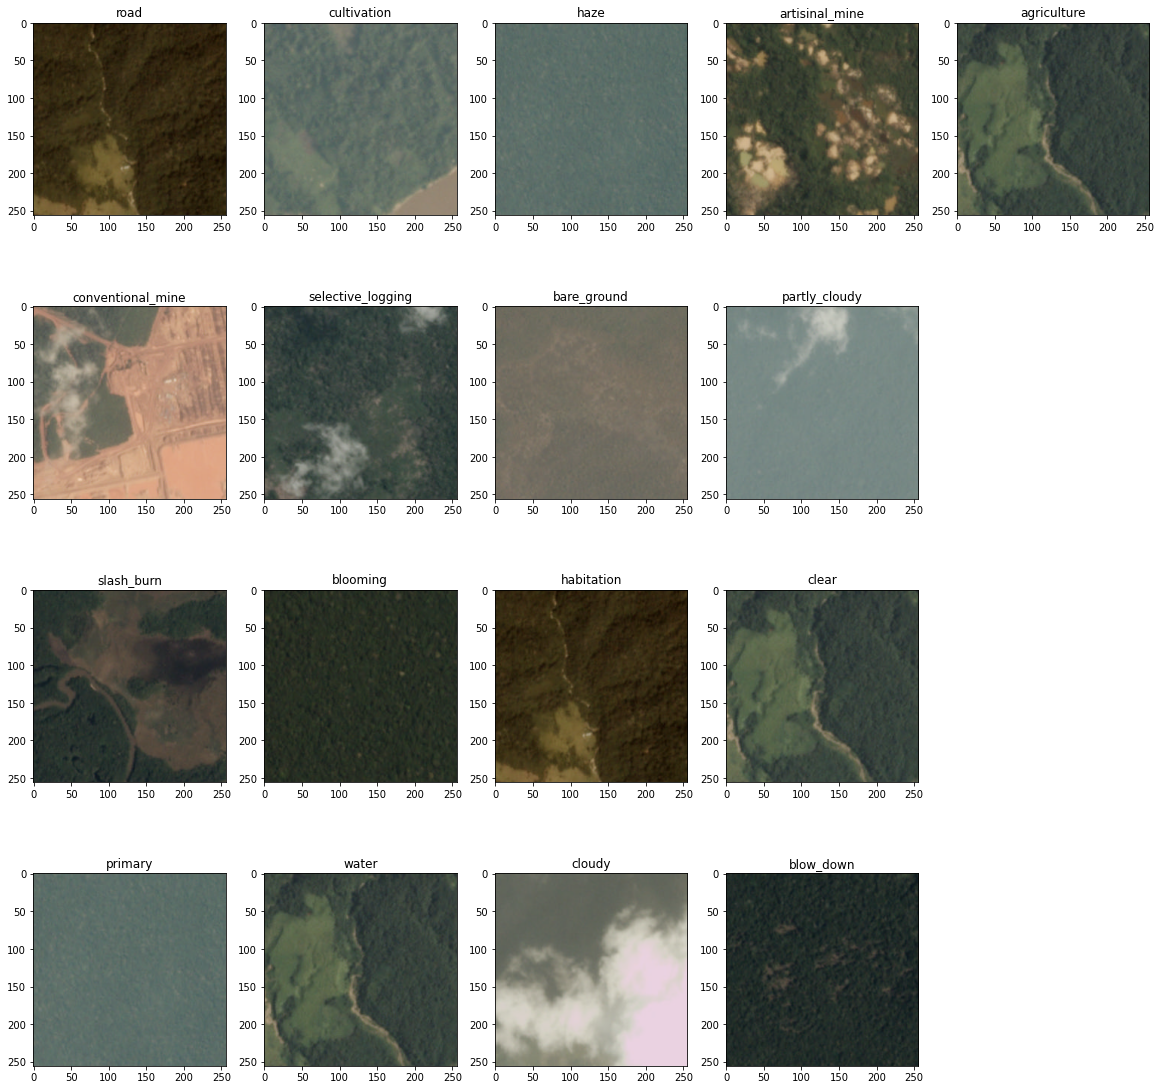

In [ ]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

In [ ]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [ ]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg") for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [ ]:
tsne = TSNE(
    n_components=2,
    init="random",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=2,
)
X_embedded = tsne.fit_transform(X_train_sample)
X_embedded.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.012s...
[t-SNE] Computed neighbors for 600 samples in 0.218s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 7.348660
[t-SNE] Computed conditional probabilities in 0.046s
[t-SNE] Iteration 50: error = 74.7133026, gradient norm = 0.4094625 (50 iterations in 0.220s)
[t-SNE] Iteration 100: error = 77.4693451, gradient norm = 0.3792830 (50 iterations in 0.145s)
[t-SNE] Iteration 150: error = 79.5560760, gradient norm = 0.3632595 (50 iterations in 0.162s)
[t-SNE] Iteration 200: error = 80.6612320, gradient norm = 0.3605570 (50 iterations in 0.145s)
[t-SNE] Iteration 250: error = 78.3437347, gradient norm = 0.3711865 (50 iterations in 0.141s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.343735
[t-SNE] Iteration 300: error = 1.0572913, gradient norm = 0.0061890 (50 iterations in 0.124s)
[t-SNE] Iteration 350: error = 0.9620376, gradient norm = 0.0009592 (

(600, 2)

In [ ]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

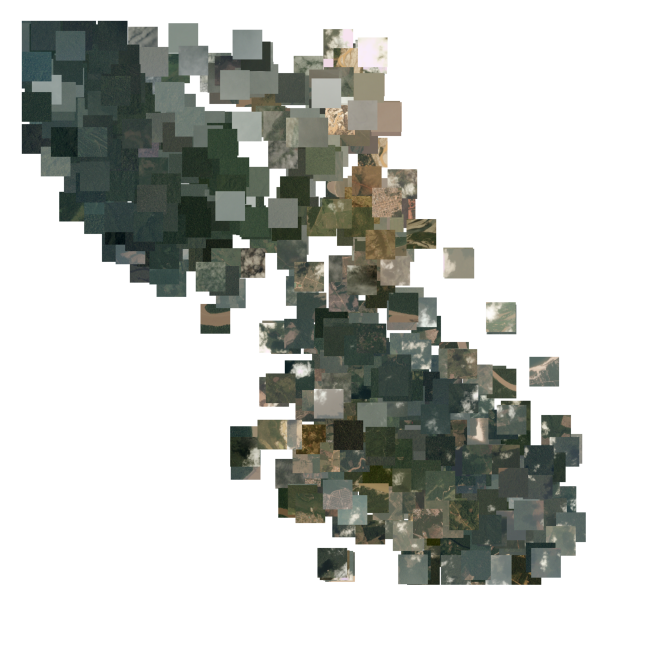

In [ ]:
size_img = 1000
offset_img = 50
h = w = int(offset_img / 2)

X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
X_scaled = (X_scaled * size_img).astype(int)
X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

img_tsne = np.ones((size_img+2*offset_img, size_img+2*offset_img, 3), dtype=np.uint8) * 255
for idx in range(X_scaled.shape[0]):
    x, y = X_scaled[idx][0], X_scaled[idx][1]
    img = fetch_img(path_files[idx], h, w)
    img_tsne[x-w:x+w, y-h:y+h, :] = img

fig = plt.figure(figsize=(12, 12))
plt.imshow(img_tsne);
plt.axis("off");

In [ ]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      )
    ])
    return transform_train, transform_val

In [ ]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise AmazonDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
    def custom_augment(self, img):
        """
        Discrete rotation and horizontal flip.
        Random during training and non random during testing for TTA.
        Not implemented in torchvision.transforms, hence this function.
        """
        choice = np.random.randint(0, 6) if self.is_train else self.idx_tta
        if choice == 0:
            # Rotate 90
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if choice == 1:
            # Rotate 90 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        if choice == 2:
            # Rotate 180
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
        if choice == 3:
            # Rotate 180 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
            img = cv2.flip(img, flipCode=1)
        if choice == 4:
            # Rotate 90 counter-clockwise
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        if choice == 5:
            # Rotate 90 counter-clockwise and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        return img

In [ ]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
    ohe_tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = AmazonDataset(df_train, ohe_tags_train, transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

In [ ]:
df_train, df_val = train_test_split(df_class, test_size=.2)

ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape

<ipython-input-15-d1e7ca85d47c>:51: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)



(torch.Size([64, 3, 224, 224]), torch.Size([64, 17]))

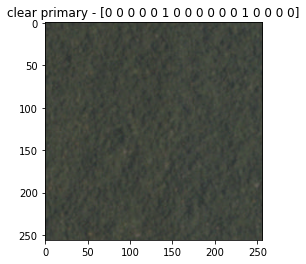

In [ ]:
ds_train.load_img(5)

In [ ]:
def get_model():
    # Train from scratch
    model = models.alexnet(pretrained=True)
    # Feature Vector
    for param in model.parameters():
      param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
    model.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=9216, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      # nn.Dropout(p=0.5, inplace=False),
      # nn.Linear(in_features=4096, out_features=4096, bias=True),
      # nn.ReLU(inplace=True),
      nn.Linear(in_features=4096, out_features=1000, bias=True),  
      nn.ReLU(inplace=True),
      nn.Linear(in_features=1000, out_features=17, bias=True), 
      nn.Sigmoid() 
    ) 
    # Fine Tune 
    # model = nn.Sequential(
    #     model,
    #     nn.ReLU(inplace=True),
    #     nn.Linear(in_features=1000, out_features=17, bias=True),      
    #     nn.Sigmoid()
    # )     
 
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

In [ ]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

In [ ]:
def train_model(dl_train, dl_val, idx_fold):
    model, optimizer, loss_fn = get_model()
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = 50
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    torch.save(model, f"resnet18_fold{idx_fold}.pth")
    pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

In [ ]:
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.0625% (66)
val bare_ground: 2.1250% (17)

train selective_logging: 0.6250% (20)
val selective_logging: 1.0000% (8)

train artisinal_mine: 0.8438% (27)
val artisinal_mine: 1.1250% (9)

train blooming: 0.8438% (27)
val blooming: 1.7500% (14)

train slash_burn: 0.6562% (21)
val slash_burn: 0.5000% (4)

train blow_down: 0.2188% (7)
val blow_down: 0.5000% (4)

train conventional_mine: 0.0625% (2)
val conventional_mine: 0.1250% (1)



In [ ]:
train_model(dl_train, dl_val, 0)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 0/50 -- train loss: 0.19937844410538674, val loss: 0.14066074616633928 -- train fbeta_score: 0.8034545334591399, val fbeta_score: 0.8715418824250166


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 1/50 -- train loss: 0.12914471924304963, val loss: 0.12416414458018082 -- train fbeta_score: 0.8832801113004612, val fbeta_score: 0.8883030793427885


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 2/50 -- train loss: 0.11541032627224922, val loss: 0.12329536275221752 -- train fbeta_score: 0.8979609372561626, val fbeta_score: 0.8924439904925776


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 3/50 -- train loss: 0.1087373922765255, val loss: 0.12315398626602612 -- train fbeta_score: 0.9036909042195599, val fbeta_score: 0.8854621140772383


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 4/50 -- train loss: 0.10131552323698997, val loss: 0.11042069930296677 -- train fbeta_score: 0.9109911258850383, val fbeta_score: 0.9035372427007047


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 5/50 -- train loss: 0.09576964721083642, val loss: 0.11420496209309651 -- train fbeta_score: 0.9175356219013444, val fbeta_score: 0.8972814287896425


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 6/50 -- train loss: 0.09055639483034611, val loss: 0.11280383857396933 -- train fbeta_score: 0.9205174174250588, val fbeta_score: 0.898203611024188


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 7/50 -- train loss: 0.08134436778724194, val loss: 0.10290013998746872 -- train fbeta_score: 0.9288442478429642, val fbeta_score: 0.9094328741139267


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 8/50 -- train loss: 0.07691022142767906, val loss: 0.1073569065103164 -- train fbeta_score: 0.9319652842572094, val fbeta_score: 0.9051067720174253


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 9/50 -- train loss: 0.07594245061278343, val loss: 0.1047867823105592 -- train fbeta_score: 0.9353331805060613, val fbeta_score: 0.9064463482180382


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 10/50 -- train loss: 0.07503967098891735, val loss: 0.10441147707975827 -- train fbeta_score: 0.9353439644038279, val fbeta_score: 0.9104549553258791


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 11/50 -- train loss: 0.0729596921056509, val loss: 0.10869400547100948 -- train fbeta_score: 0.9357170145854833, val fbeta_score: 0.9075831304572207


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 12/50 -- train loss: 0.07295308969914913, val loss: 0.1070411904500081 -- train fbeta_score: 0.9364866478175173, val fbeta_score: 0.907182045420155


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 13/50 -- train loss: 0.07225757293403148, val loss: 0.10670786580214134 -- train fbeta_score: 0.9373429524775527, val fbeta_score: 0.9083267261965848


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 14/50 -- train loss: 0.07050986051559448, val loss: 0.10652219504117966 -- train fbeta_score: 0.9395610475345836, val fbeta_score: 0.9072954106422969


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 15/50 -- train loss: 0.06988497629761696, val loss: 0.10586136407577075 -- train fbeta_score: 0.9388988589370487, val fbeta_score: 0.9069724390418961


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 16/50 -- train loss: 0.06945013478398324, val loss: 0.10782352949564274 -- train fbeta_score: 0.939486042448452, val fbeta_score: 0.9073794657847103


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 17/50 -- train loss: 0.06925637297332286, val loss: 0.10764759549727806 -- train fbeta_score: 0.9416303854484134, val fbeta_score: 0.907964615818938


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 18/50 -- train loss: 0.07040476053953171, val loss: 0.10565649030300286 -- train fbeta_score: 0.9378851377467149, val fbeta_score: 0.9098647003402612


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 19/50 -- train loss: 0.06953608125448227, val loss: 0.10478937167387742 -- train fbeta_score: 0.939787506656182, val fbeta_score: 0.9094336079504474


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 20/50 -- train loss: 0.06910707496106624, val loss: 0.10566218483906525 -- train fbeta_score: 0.941367839342906, val fbeta_score: 0.9075288829583239


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 21/50 -- train loss: 0.06999459989368916, val loss: 0.10524631979373786 -- train fbeta_score: 0.9400285050801834, val fbeta_score: 0.9110320899172294


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 22/50 -- train loss: 0.06826643124222756, val loss: 0.1074071921981298 -- train fbeta_score: 0.9417662789475333, val fbeta_score: 0.9077116784946095


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 23/50 -- train loss: 0.06906009435653687, val loss: 0.10617575679834072 -- train fbeta_score: 0.9405383048175089, val fbeta_score: 0.9095272525906734


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 24/50 -- train loss: 0.06892451636493206, val loss: 0.1075980720611719 -- train fbeta_score: 0.9404425182587207, val fbeta_score: 0.9059870390465892


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 25/50 -- train loss: 0.07013388864696025, val loss: 0.10699990506355579 -- train fbeta_score: 0.9394277551813278, val fbeta_score: 0.9083603205655723


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 26/50 -- train loss: 0.06915179006755352, val loss: 0.10544382666166012 -- train fbeta_score: 0.940646143856838, val fbeta_score: 0.9084566722283209


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 27/50 -- train loss: 0.0691286188364029, val loss: 0.10798826355200547 -- train fbeta_score: 0.9411417746231954, val fbeta_score: 0.9084338435799405


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 28/50 -- train loss: 0.06980814233422279, val loss: 0.1042514368891716 -- train fbeta_score: 0.9412544213439414, val fbeta_score: 0.9079828653318992


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 29/50 -- train loss: 0.06967211239039899, val loss: 0.1071646070251098 -- train fbeta_score: 0.9399722877078039, val fbeta_score: 0.9089057031771824


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 30/50 -- train loss: 0.06906831368803978, val loss: 0.10520667181565212 -- train fbeta_score: 0.940414039052998, val fbeta_score: 0.9104829109000931


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 31/50 -- train loss: 0.0688447656482458, val loss: 0.10931795778182837 -- train fbeta_score: 0.9404681097127312, val fbeta_score: 0.9088004652984811


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 32/50 -- train loss: 0.06949111379683018, val loss: 0.10387829003425744 -- train fbeta_score: 0.9393039249658619, val fbeta_score: 0.9084335262643699


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 33/50 -- train loss: 0.06898707583546639, val loss: 0.10886675234024341 -- train fbeta_score: 0.939830976114734, val fbeta_score: 0.9077362129285389


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 34/50 -- train loss: 0.06797056578099728, val loss: 0.10772303491830826 -- train fbeta_score: 0.9410867079950347, val fbeta_score: 0.9086579509062851


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 35/50 -- train loss: 0.06857853055000306, val loss: 0.1054584005704293 -- train fbeta_score: 0.9413241538971309, val fbeta_score: 0.9106696925506871


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 36/50 -- train loss: 0.06921265043318271, val loss: 0.10730343140088595 -- train fbeta_score: 0.9397273261926113, val fbeta_score: 0.9079215422840516


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 37/50 -- train loss: 0.06966556087136269, val loss: 0.10507032217887732 -- train fbeta_score: 0.9391024420705797, val fbeta_score: 0.9093269758441064


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 38/50 -- train loss: 0.06918270356953143, val loss: 0.10611013437692936 -- train fbeta_score: 0.9418809600217378, val fbeta_score: 0.9088149441881836


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 39/50 -- train loss: 0.06872503377497197, val loss: 0.10511736256571916 -- train fbeta_score: 0.9386064737178499, val fbeta_score: 0.9071047791700722


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 40/50 -- train loss: 0.06909384787082672, val loss: 0.10545188876298758 -- train fbeta_score: 0.9406136186009288, val fbeta_score: 0.9071019439499238


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 41/50 -- train loss: 0.06919493809342385, val loss: 0.10494525730609894 -- train fbeta_score: 0.9402489286157463, val fbeta_score: 0.9099014194974666


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 42/50 -- train loss: 0.06905193321406841, val loss: 0.10714906683334938 -- train fbeta_score: 0.9406411175866316, val fbeta_score: 0.908747876649863


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 43/50 -- train loss: 0.06843887850642204, val loss: 0.1097629706446941 -- train fbeta_score: 0.9419311857357231, val fbeta_score: 0.9072315038897649


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 44/50 -- train loss: 0.06940396457910537, val loss: 0.10750262611187421 -- train fbeta_score: 0.9407212420994585, val fbeta_score: 0.9088216342087878


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 45/50 -- train loss: 0.06847913421690464, val loss: 0.10535069039234748 -- train fbeta_score: 0.942285895079851, val fbeta_score: 0.9083531217161769


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 46/50 -- train loss: 0.06947768397629261, val loss: 0.10602104090727292 -- train fbeta_score: 0.9413314904529768, val fbeta_score: 0.9075572749544548


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 47/50 -- train loss: 0.06950740836560726, val loss: 0.105810607282015 -- train fbeta_score: 0.9404513564983723, val fbeta_score: 0.9098428750836702


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 48/50 -- train loss: 0.06900651820003986, val loss: 0.10756645237024014 -- train fbeta_score: 0.9411010674586296, val fbeta_score: 0.9071848071744734


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

epoch: 49/50 -- train loss: 0.06857898585498333, val loss: 0.10815899360638398 -- train fbeta_score: 0.94146333374097, val fbeta_score: 0.9059903274278589


In [ ]:
model = torch.load("resnet18_fold0.pth")
train_results = pickle.load(open("train_results_fold0.pkl", "rb"))

In [ ]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "F2 scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()

In [ ]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_hat proba | Y = 0")
]).show()

In [ ]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = fbeta_score(Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs

In [ ]:
threshs = find_best_thresholds(Y_hat_val, Y_val)

  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.15, 0.24, 0.21, 0.1, 0.06, 0.16, 0.17, 0.05, 0.27, 0.23, 0.2, 0.16, 0.08, 0.25, 0.12, 0.28, 0.1] -- best score: 0.9165941283425414


In [ ]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

In [ ]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()

In [ ]:
!echo $(ls ./Amazon/test-jpg | wc -l)

4000


In [ ]:
def get_test_data(idx_tta):
    path_test_table = "./Amazon"
    path_test_file_1 = "./Amazon/test-jpg"
    # path_test_file_2 = "../input/planets-dataset/test-jpg-additional/test-jpg-additional"
    # file_count = len(os.listdir(path_test_file_1)) + len(os.listdir(path_test_file_2))
    file_count = len(os.listdir(path_test_file_1))
    df_test = pd.read_csv(os.path.join(path_test_table, "sample_submission.csv"))
    
    assert df_test.shape[0] == file_count # sanity check
    
    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val = get_transforms()
    ds_test = AmazonDataset(
        # df_test, ohe_tags_test, transform_val, path=[path_test_file_1, path_test_file_2],
        df_test, ohe_tags_test, transform_val, path=[path_test_file_1],
        is_train=False, idx_tta=idx_tta
    )
    dl_test = DataLoader(
        ds_test, shuffle=False, batch_size=32, collate_fn=ds_test.collate_fn
    )
    
    return dl_test, df_test

In [ ]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()

In [ ]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["tags"] = test_tags
df_test.to_csv("my_sample_submission.csv", index=False)